In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d arjuntejaswi/plant-village --force

 99% 324M/329M [00:01<00:00, 185MB/s]
100% 329M/329M [00:01<00:00, 180MB/s]


In [18]:
import zipfile
zip_ref = zipfile.ZipFile('/content/notleaf.zip', 'r')
zip_ref.extractall('/content/PlantVillage/Not_Leaf')
zip_ref.close()

In [17]:
import shutil

# Specify the folder path you want to delete
folder_path = '/content/PlantVillage/Tomato_healthy'

# Delete the folder and its contents
shutil.rmtree(folder_path)

In [ ]:
from PIL import Image
import os

# Define the input and output directories
input_dir = '/content/PlantVillage/not_Leaf'
output_dir = '/content/PlantVillage/notleaf'

# Ensure that the output directory exists, create it if necessary
os.makedirs(output_dir, exist_ok=True)

# Loop through all files in the input directory
for filename in os.listdir(input_dir):
    # Check if the file is an image (you may need to adjust the condition based on your file types)
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        # Open the image file
        with Image.open(os.path.join(input_dir, filename)) as img:
            # Resize the image to the desired size (e.g., 256x256)
            resized_img = img.resize((256, 256))

            # Save the resized image to the output directory
            resized_img.save(os.path.join(output_dir, filename))

print("Image resizing completed.")


Image resizing completed.


In [19]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [20]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (256,256),
    batch_size = 32
)

Found 4233 files belonging to 4 classes.


In [21]:
train_data = data.take(106)
temp = data.skip(106)

val_data = temp.take(14)
test_data = temp.skip(14)

print(len(train_data))
print(len(val_data))
print(len(test_data))

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

106
14
13


In [ ]:
train_data.shape

AttributeError: '_PrefetchDataset' object has no attribute 'shape'

In [22]:
scaling_layer = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1.0/255)
])

aug_layer = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

img_size = (32,256,256,3)

model = models.Sequential([
    scaling_layer,
    aug_layer,
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = img_size),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(4,activation='softmax')
])

In [23]:
model.build(input_shape = img_size)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [24]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [25]:
history = model.fit(
    train_data,
    epochs = 50,
    batch_size = 32,
    verbose = 1,
    validation_data = val_data
)

Epoch 1/50
106/106 [==============================] - 22s 90ms/step - loss: 0.9800 - accuracy: 0.5510 - val_loss: 0.7340 - val_accuracy: 0.6629
Epoch 2/50
106/106 [==============================] - 6s 59ms/step - loss: 0.6402 - accuracy: 0.7323 - val_loss: 0.5275 - val_accuracy: 0.7768
Epoch 3/50
106/106 [==============================] - 6s 59ms/step - loss: 0.5401 - accuracy: 0.7857 - val_loss: 0.4438 - val_accuracy: 0.8415
Epoch 4/50
106/106 [==============================] - 6s 59ms/step - loss: 0.4688 - accuracy: 0.8152 - val_loss: 0.3636 - val_accuracy: 0.8638
Epoch 5/50
106/106 [==============================] - 6s 60ms/step - loss: 0.3967 - accuracy: 0.8576 - val_loss: 0.3620 - val_accuracy: 0.8817
Epoch 6/50
106/106 [==============================] - 6s 60ms/step - loss: 0.3735 - accuracy: 0.8700 - val_loss: 0.3248 - val_accuracy: 0.8839
Epoch 7/50
106/106 [==============================] - 6s 58ms/step - loss: 0.3111 - accuracy: 0.8927 - val_loss: 0.3691 - val_accuracy: 0.879

In [33]:
model.save("./saved_model.keras")

In [34]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [35]:
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

In [27]:
scores = model.evaluate(test_data)

13/13 [==============================] - 0s 23ms/step - loss: 0.0494 - accuracy: 0.9771


In [28]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = data.class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


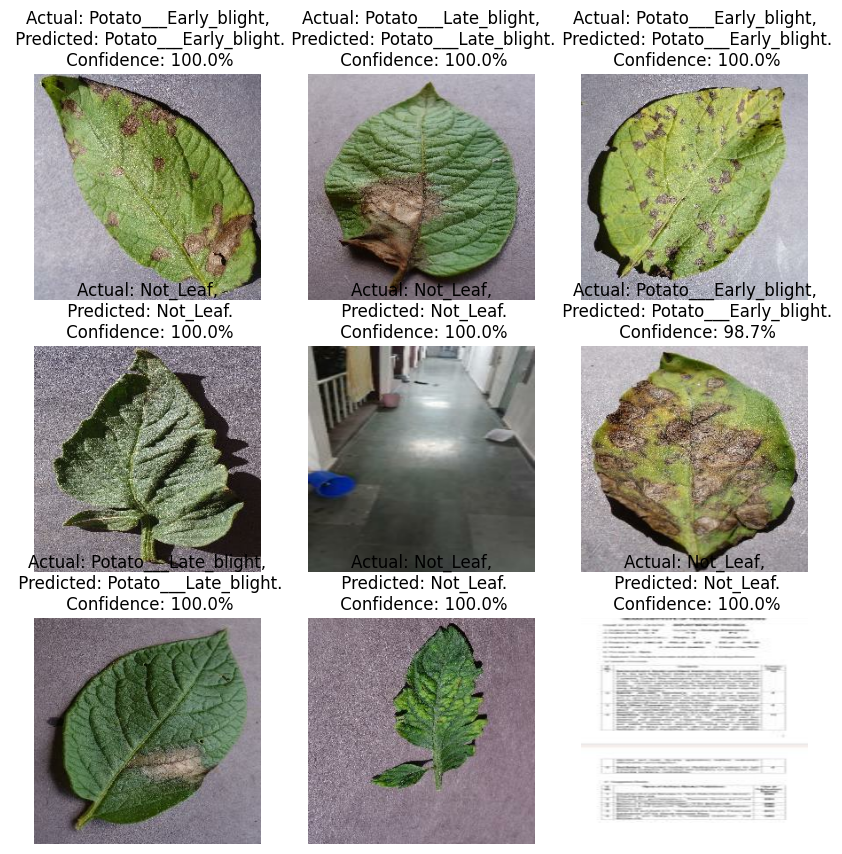

In [32]:
plt.figure(figsize=(10, 10))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = data.class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")